In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

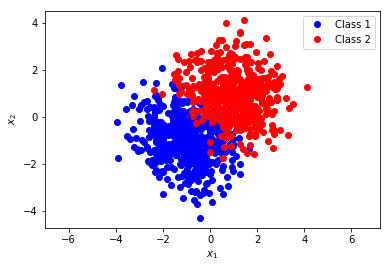

In [2]:
# Class 1
x = np.random.multivariate_normal([-1, -1], [[1, -.25], [-.25, 1]], 500).T
x_test = np.random.multivariate_normal([-1, -1], [[1, -.25], [-.25, 1]],500).T
#Class 2
y = np.random.multivariate_normal([1, 1], [[1, -.25], [-.25, 1]], 500).T
y_test = np.random.multivariate_normal([1, 1], [[1, -.25], [-.25, 1]], 500).T
plt.plot(x[0], x[1], 'o', c='b')
plt.plot(y[0], y[1], 'o', c='r')
plt.axis('equal')
plt.xlabel('$x_1$')  # use latex in the figure axis labels
plt.ylabel('$x_2$')
plt.legend(("Class 1", "Class 2"))
plt.show()


In [3]:
#segregate to sample datas with 10% and 25% labeled training data
#10% training labeled data
random_x_y = np.random.randint(500, size=int(0.10*500))
#print(random_x_y.shape)
x_10=x[:,random_x_y]
y_10=y[:,random_x_y]
x_90=np.delete(x,random_x_y,1)
y_90=np.delete(y,random_x_y,1)
#print(x_90.shape,random_x_y.shape,x.shape,y_90.shape,y.shape)
X=np.stack((x_10[0][:], x_10[1][:]), axis=-1)
Y=np.stack((y_10[0][:], y_10[1][:]), axis=-1)
Z_10=np.concatenate((X, Y), axis=0)      #labelled input data
O_10=np.concatenate((np.full((50), 0), np.full((50), 1)), axis=0)    #output of labelled data
#unlaballed data
X=np.stack((x_90[0][:], x_90[1][:]), axis=-1)
Y=np.stack((y_90[0][:], y_90[1][:]), axis=-1)
Z_90=np.concatenate((X, Y), axis=0)      

#25% training labeled data
random_x_y = np.random.randint(500, size=int(0.25*500))
x_25=x[:,random_x_y]
y_25=y[:,random_x_y]
x_75=np.delete(x,random_x_y,1)
y_75=np.delete(y,random_x_y,1)
#print(x_75.shape,random_x_y.shape,x.shape,y_75.shape,y.shape)
X=np.stack((x_25[0][:], x_25[1][:]), axis=-1)
Y=np.stack((y_25[0][:], y_25[1][:]), axis=-1)
Z_25=np.concatenate((X, Y), axis=0)      #labelled input data
O_25=np.concatenate((np.full((125), 0), np.full((125), 1)), axis=0)    #output of labelled data
#unlabelled
X=np.stack((x_75[0][:], x_75[1][:]), axis=-1)
Y=np.stack((y_75[0][:], y_75[1][:]), axis=-1)
Z_75=np.concatenate((X, Y), axis=0)  
#print(x_10.shape,y_10.shape,x_25.shape,y_25.shape)

#testing data commmon for all
X_test=np.stack((x_test[0][:], x_test[1][:]), axis=-1)
Y_test=np.stack((y_test[0][:], y_test[1][:]), axis=-1)
Z_test=np.concatenate((X_test, Y_test), axis=0)
O_test=np.concatenate((np.full((500), 0), np.full((500), 1)), axis=0)

In [4]:
def self_training(Z_labelled_,O_labelled_,Z_unlabelled_,sample_rate_unlabelled,Z_test,O_test):
    lr = LogisticRegression(C=1.)
    Z_labelled=Z_labelled_
    O_labelled=O_labelled_
    Z_unlabelled=Z_unlabelled_
    #required unlabelled data to move to labelled
    len_labelled_data=sample_rate_unlabelled*len(Z_unlabelled)
    i=0
    confidence=0.90
    while(1):
        lr.fit(Z_labelled,O_labelled)
        if(len_labelled_data >= len(Z_unlabelled) or i>20):
            print("Testing error ",(1-lr.score(Z_test,O_test))*100,"%","Shape labelled & unlabelled",Z_labelled.shape,Z_unlabelled.shape)
            break
        #predict probability of the unlabelled class
        temp=lr.predict_proba(Z_unlabelled)
        #index if confidence in class 1 is greater than 0.95
        temp_index_class1=np.asarray(np.where(temp[:,0] >confidence))
        
        #temp_index_class1.shape=(len(temp_index_class1[0,]),1)
        #print(temp_index_class1.shape)
        #put this values in labelled data with corresponding output label
        Z_labelled=np.concatenate((Z_labelled, Z_unlabelled[temp_index_class1[0,:],:]), axis=0)  
        O_labelled=np.concatenate((O_labelled, np.full((len(temp_index_class1[0,:])), 0)), axis=0)  
        #index if confidence in class 2 is greater than 0.95
        temp_index_class2=np.asarray(np.where(temp[:,1] >confidence))
        #put this values in labelled data with corresponding output label
        Z_labelled=np.concatenate((Z_labelled, Z_unlabelled[temp_index_class2[0,:],:]), axis=0)  
        O_labelled=np.concatenate((O_labelled, np.full((len(temp_index_class2[0,:])), 1)), axis=0)   
        #Now clean the unlabelled data from the labbelled data
        Z_2=np.concatenate((temp_index_class1[0,:], temp_index_class2[0,:]), axis=0) 
        Z_unlabelled=np.delete(Z_unlabelled,Z_2,0)
        i=i+1

        
    return 0

In [5]:
print("For 10% training labelled data")
print("1st time when only training labelled data is used for classification")
self_training(Z_10,O_10,Z_90,1,Z_test,O_test)
print("During the self training process when pseudo labels are used")
self_training(Z_10,O_10,Z_90,0.5,Z_test,O_test)
print("After self-training is completed")
self_training(Z_10,O_10,Z_90,0,Z_test,O_test)


For 10% training labelled data
1st time when only training labelled data is used for classification
Testing error  4.8 % Shape labelled & unlabelled (100, 2) (902, 2)
During the self training process when pseudo labels are used
Testing error  4.9 % Shape labelled & unlabelled (805, 2) (197, 2)
After self-training is completed
Testing error  4.8 % Shape labelled & unlabelled (886, 2) (116, 2)


0

In [6]:
print("For 25% training labelled data")
print("1st time when only training labelled data is used for classification")
self_training(Z_25,O_25,Z_75,1,Z_test,O_test)
print("During the self training process when pseudo labels are used")
self_training(Z_25,O_25,Z_75,0.5,Z_test,O_test)
print("After self-training is completed")
self_training(Z_25,O_25,Z_75,0,Z_test,O_test)

For 25% training labelled data
1st time when only training labelled data is used for classification
Testing error  4.7 % Shape labelled & unlabelled (250, 2) (782, 2)
During the self training process when pseudo labels are used
Testing error  4.9 % Shape labelled & unlabelled (856, 2) (176, 2)
After self-training is completed
Testing error  4.7 % Shape labelled & unlabelled (909, 2) (123, 2)


0